In [24]:
import numpy as np
import pandas as pd
import random
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from textblob import TextBlob
from scipy import stats
from sklearn.linear_model import LinearRegression

sns.set()
warnings.simplefilter(action='ignore', category=FutureWarning)

#### Funciones

In [2]:
def word_sentiments(word, tweet_df):
    tweet_batch = tweet_df.loc[tweet_df.loc[:, 'text'].str.contains(fr'\b{word}')].copy()
    
    sentiments = []
    for tweet in tweet_batch['text']:
        sentiments.append(TextBlob(tweet).sentiment.polarity)
    
    tweet_batch['sentiment'] = sentiments
    
    return tweet_batch

In [26]:
def get_companies_transactions(companies, tweets_df, stocks_df, window):
    
    polarities, differences, related_company = [] , [], []
    for company in companies:
        
        tweets = word_sentiments(company, tweets_df)
        company_stocks = stocks_df.loc[stocks_df.loc[:,"name"].str.contains(fr'\b{company.upper()}')].copy()
        
        for _, tweet in tweets.iterrows():
            
            open_ = company_stocks.loc[company_stocks["date"]==tweet.created_at.date(), "open"]
            
            if len(open_) == 0:
                for _, row in company_stocks.iterrows():
                    if row.date.date() > tweet.created_at.date():
                        open_ = company_stocks.loc[company_stocks['date'] == row.date, 'open']
                        break
                        
            close_ = company_stocks.loc[open_.index + window,"close"]
            dif_ = (close_.values - open_.values)/open_.values*100
            
            polarities.append(tweet.sentiment)
            differences.append(dif_)
            related_company.append(company)
    
    plot_stats(polarities, differences)
    
    return polarities, differences, related_company        
    

In [26]:
def plot_stats(polarities, differences):
    
    plt.xlim((-1, 1))
    plt.ylim((-5, 5))
    
    plt.xlabel('Tweet polarity')
    plt.ylabel('Stock trend')
    plt.title('Trump tweets vs stocks')
    
    plt.scatter(polarities, differences, c=differences, cmap='RdYlGn')
    
    plt.grid(True)
    plt.show()

#### Tweets

In [4]:
tweets = pd.read_csv('trump_tweets.csv')

##### Object column to datetime

In [5]:
tweets.loc[:,'created_at'] = pd.to_datetime(tweets.loc[:,'created_at'])

Filtramos las fechas fuera de scope

In [6]:
tweets = tweets.loc[tweets['created_at'] >= datetime.strptime('2017-01-20', "%Y-%m-%d").date()]
tweets = tweets.loc[tweets['created_at'] <= datetime.strptime('2018-08-24', "%Y-%m-%d").date()]

##### To lowercase

In [7]:
tweets['text'] = tweets['text'].str.lower() 

#### Bolsa

In [8]:
bolsa = pd.read_csv('bolsa.csv', index_col=0)
bolsa = bolsa.reset_index(drop=True)

##### Value at open vs value at close

In [9]:
bolsa['difference'] = (bolsa['close'] - bolsa['open'])/(bolsa['open']) * 100

##### Column stating if the values went down 

In [10]:
bolsa['goes_down'] = bolsa['difference'] < 0

##### To datetime

In [11]:
bolsa.loc[:,'date'] = pd.to_datetime(bolsa.loc[:,'date'])

#### Tickers

In [12]:
tickers = pd.read_csv('historical_stocks.csv')

##### Bolsa w/ extended info

In [13]:
bolsa_ext = pd.merge(bolsa, tickers, on=['ticker'])

##### Tweets por cada empresa

In [14]:
empresas = ['amazon', 'facebook', 'general motors', 'toyota', 'alphabet', 'ibm', 'apple', 'microsoft', 'netflix', 'american airlines', 'amd', 'ebay', 'tesla', 'alibaba']

In [15]:
tweet_count = []
tweet_collection = []
for empresa in empresas:
    batch = word_sentiments(empresa, tweets)
    tweet_count.append(len(batch))
    tweet_collection.append(batch)

zipped = list(zip(empresas, tweet_count))

for pair in zipped:
    print(pair)

('amazon', 21)
('facebook', 8)
('general motors', 1)
('toyota', 3)
('alphabet', 0)
('ibm', 0)
('apple', 4)
('microsoft', 0)
('netflix', 0)
('american airlines', 1)
('amd', 0)
('ebay', 0)
('tesla', 0)
('alibaba', 0)


#### Tweet sentiment

##### Filtering

Necesario eliminar 'APLE'; coincide con APPLE

In [16]:
bolsa_ext = bolsa_ext[~bolsa_ext['ticker'].isin(['APLE'])]

#### Testing

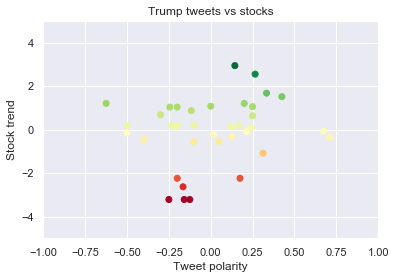

In [28]:
pol, diff, rel =  get_companies_transactions(empresas, tweets, bolsa_ext, window=0)

In [18]:
pol = np.asarray(pol)
diff = np.asarray(diff)
diff = diff.reshape(-1)

In [19]:
print(pol.shape)
print(diff.shape)

(38,)
(38,)


In [21]:
coe_pearson = stats.pearsonr(pol, diff)

In [23]:
print('Hemos obtenido un r = {} con un p-valor de: {}' .format(coe_pearson[0], coe_pearson[1]))

Hemos obtenido un r = 0.18751979333689067 con un p-valor de: 0.2595855740971561


#### Regresión

In [42]:
X_pred = np.empty(shape=[10,])
for i in range(0,10):
    a = random.uniform(-1, 1)
    X_pred[i] = a

In [46]:
X_pred = X_pred.reshape(-1 , 1)

In [47]:
X_pred

array([[ 0.82870887],
       [-0.61291622],
       [-0.87587815],
       [-0.51520295],
       [-0.63884743],
       [ 0.96549726],
       [-0.55921602],
       [ 0.05453754],
       [-0.95300532],
       [-0.07513171]])

In [49]:
pol = pol.reshape(-1,1)
diff = diff.reshape(-1,1)

In [50]:
print(pol.shape)
print(diff.shape)

(38, 1)
(38, 1)


In [51]:
regr = LinearRegression()

regr.fit(pol, diff)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Coeficiente de la regresión: 
 [[0.90276864]]


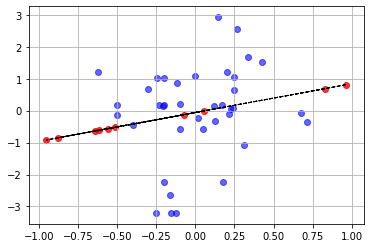

In [90]:
predicts = regr.predict(X_pred)

print('Coeficiente de la regresión: \n', regr.coef_)

# Plot outputs
plt.grid()
plt.scatter(pol, diff,  color='blue', alpha = 0.6)
plt.scatter(X_pred, predicts,  color='red', alpha = 0.8)
plt.plot(X_pred, predicts, color='black', linewidth=1, linestyle='dashed')
plt.show()